In [17]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model


def model(dim=10):
    numpyro.sample("y", dist.Normal(0, 3))
    numpyro.sample("x", dist.Normal(jnp.zeros(dim - 1), 4))


model_info = initialize_model(jr.PRNGKey(0), model)
potential_fn = model_info.potential_fn

22.764648


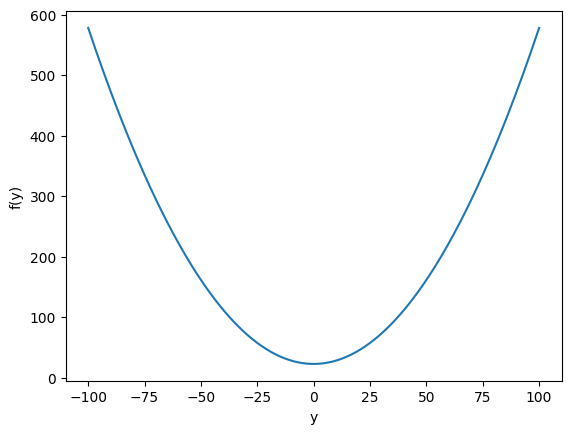

In [18]:
print(potential_fn({"y": jnp.array(0.0), "x": jnp.zeros((9,))}))


@jax.jit
@jax.vmap
def f(y):
    return potential_fn({"y": y, "x": jnp.zeros((9,))})


# plot f
y = jnp.linspace(-100.0, 100.0, 300)
plt.plot(y, f(y))
plt.xlabel("y")
plt.ylabel("f(y)")
plt.show()

In [19]:
print(model_info.param_info)

ParamInfo(z={'y': Array(-1.5785241, dtype=float32), 'x': Array([-0.14252472,  1.7450352 , -0.6388316 ,  1.1764917 , -1.9091988 ,
        0.6505232 ,  1.3845634 ,  0.01283121,  0.94347763], dtype=float32)}, potential_energy=Array(23.269743, dtype=float32), z_grad={'x': Array([-0.00890779,  0.1090647 , -0.03992698,  0.07353073, -0.11932492,
        0.0406577 ,  0.08653522,  0.00080195,  0.05896735], dtype=float32), 'y': Array(-0.17539158, dtype=float32)})


In [21]:
def model_logreg(data, labels):
    alpha = numpyro.sample("alpha", dist.Exponential(0.01))
    W = numpyro.sample("W", dist.Normal(jnp.zeros(7), 1.0 / alpha))
    logits = jnp.sum(W * data, axis=-1)
    return numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=labels)


logreg_info = initialize_model(
    jr.PRNGKey(0),
    model_logreg,
    model_kwargs={"data": jnp.zeros((10, 7)), "labels": jnp.zeros(10)},
)
print(logreg_info.param_info)


def alpha_W_to_array(dct: dict):
    return jnp.concatenate([jnp.reshape(dct["alpha"], (1,)), dct["W"]])


def array_to_alpha_W(arr: jnp.ndarray):
    return {"alpha": arr[0], "W": arr[1:]}


def pot_fn(arr: jnp.ndarray):
    dct = array_to_alpha_W(arr)
    return logreg_info.potential_fn(dct)


arr = alpha_W_to_array(logreg_info.param_info.z)
print(arr)
alpha_W = array_to_alpha_W(arr)
print(alpha_W)
print(pot_fn(arr))

ParamInfo(z={'alpha': Array(-1.5785241, dtype=float32), 'W': Array([-1.7320566 , -0.09104586,  0.15519333, -0.10743618, -1.2722244 ,
        0.2748108 ,  0.6203499 ], dtype=float32)}, potential_energy=Array(30.708458, dtype=float32), z_grad={'W': Array([-0.073701  , -0.00387411,  0.00660366, -0.00457153, -0.05413462,
        0.01169352,  0.0263966 ], dtype=float32), 'alpha': Array(-7.779955, dtype=float32)})
